In [94]:
import math


class State: 
  def __init__(self, dt): 
    self.dt = dt
    
    self.u = 0
    self.v = 0
    self.a = 0
    self.g = 0
    return None

class Material: 
  def __init__(self, T, c=5/100, m=1): 
    self.T = T
    self.c = c
    self.m = m
    
    self.k = self.m *(2 *math.pi /T)**2
    self.cc = self.c * 2 *(self.k *self.m)**0.5
    return None

  def fe(self, state, a): 
    fe = self.m *state.g
    #print( 'fe', fe )
    return fe

  def fi(self, state, a): 
    (v, u) = newmark( state, a, state.dt )

    fi = self.fm( state, a, v, u ) + self.fc( state, a, v, u ) + self.fk( state, a, v, u )
    #print( 'fi', fi )
    return fi 

  def fm(self, state, a, v, u): 
    fm = self.m *a
    return fm
  
  def fc(self, state, a, v, u): 
    fc = self.cc *v
    return fc

  def fk(self, state, a, v, u): 
    fk = self.k *u
    return fk 


def newmark(state, a, t): 
  '''
  linear Newmark for t in [0, dt]
  '''

  a1 = state.a
  v1 = state.v
  u1 = state.u
  dt = state.dt

  a2 = a

  v = v1 + a1 *t + (a2 - a1) /(2*dt) *t**2
  u = u1 + v1 *t + a1 *t**2 /2 + (a2 - a1) /(6*dt) *t**3
  return (v, u)


def force_equilibrium(state, material):
  from scipy import optimize 
  
  def function(a):
    fe = material.fe( state, a )
    fi = material.fi( state, a )

    df = fe - fi
    #print( 'df', df )
    return df 
  
  a = optimize.fsolve( function, state.a )
  return a

def response(material, gs, dt, state=None): 
  resp = dict()
  
  resp[ 'u' ] = uv = np.zeros( len(gs) )
  resp[ 'v' ] = vv = np.zeros( len(gs) )
  resp[ 'a' ] = av = np.zeros( len(gs) )

  if state is None:
    state = State( dt )

  for idx in range( len(gs) ): 
    g = gs[ idx ]

    state.g = g

    a = force_equilibrium( state, material )
    #print( g, a )
    
    (v, u) = newmark( state, a, state.dt )

    uv[ idx ] = u
    vv[ idx ] = v
    av[ idx ] = a

    state.u = u
    state.v = v
    state.a = a  
  return resp

In [123]:
import numpy as np

ts = np.linspace( 0, 10, 100 )
gs = np.sin( ts ) 

T = 0.5
dt = T /20
material = Material( T )

state = State( dt )

resp = response( material, gs, dt, state = state )

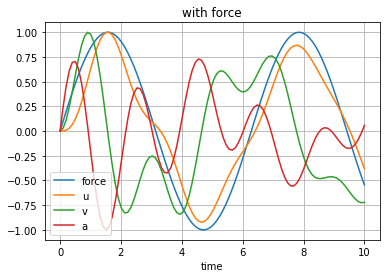

In [124]:
from matplotlib import pyplot as plt 


def scale(x, maxval=1):
  xmax = max( abs(x) )
  factor = maxval / xmax

  sx = x *factor
  return sx

(fig, ax) = plt.subplots()

ax.plot( ts, gs, label = 'force' )
for key in resp.keys():
  y = scale( resp[ key ] )
  ax.plot( ts, y, label = key )

ax.set_title( 'with force' )
ax.set_xlabel( 'time' )

ax.legend()
ax.grid()
fig.savefig( 'force.svg' )

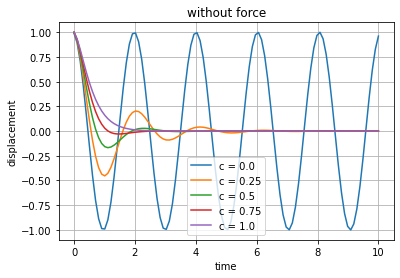

In [125]:
# free vibrations for different c 

# no force 
gs = ts * 0

(fig, ax) = plt.subplots()

for c in np.linspace( 0, 1, 5 ):
  c = round( c, 2 )

  state = State( dt )
  # impose initial displacement 
  state.u = 1  

  material = Material( T, c = c )
  resp = response( material, gs, dt, state = state )

  y = scale( resp[ 'u' ] )
  ax.plot( ts, y, label = f'c = {c}' )


ax.set_title( 'without force' )
ax.set_xlabel( 'time' )
ax.set_ylabel( 'displacement' )

ax.legend()
ax.grid()
fig.savefig( 'free.svg' )